<a href="https://colab.research.google.com/github/tejaswishetty17/Agentic-AI/blob/main/Corrective_RAG_(CRAG)_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Self-Reflective RAG with LangGraph

In practice, many have found that implementing RAG requires logical reasoning around these steps: for example, we can ask when to retrieve (based upon the question and composition of the index), when to re-write the question for better retrieval, or when to discard irrelevant retrieved documents and re-try retrieval? The term self-reflective RAG has been introduced, which captures the idea of using an LLM to self-correct poor quality retrieval and / or generations.

The basic RAG flow (shown above) simply uses a chain: the LLM determines what to generate based upon the retrieved documents. Some RAG flows use routing, where an LLM decides between, for example, different retrievers based on the question. But self-reflective RAG usually requires some kind of feedback, re-generating the question and / or re-retrieving documents. State machines are a third kind of cognitive architecture that supports loops and it well suited for this: a state machine simply lets us define a set of steps (e.g., retrieval, grade documents, re-write query) and set the transitions options between them; e.g., if our retrieved docs are not relevant, then re-write the query and re-retrieve new documents.

#Corrective RAG (CRAG)
Corrective RAG (CRAG) introduces a few interesting ideas:

* Employ a lightweight retrieval evaluator to assess the overall quality of retrieved documents for a query, returning a confidence score for each.
* Perform web-based document retrieval to supplement context if vectorstore retrieval is deemed ambiguous or irrelevant to the user query.
* Perform knowledge refinement of retrieved document by partitioning them into "knowledge strips", grading each strip, and filtering our irrelevant ones.

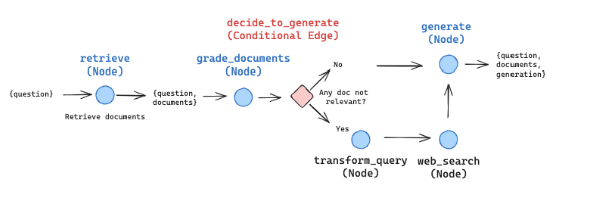

In [80]:
pip install -q langchain langchain_openai langchain_community langgraph langchain-core chromadb tiktoken langchain-openai langchainhub tavily-python #to do a google search

In [81]:
import os
os.environ["OPENAI_API_KEY"] = ""
#get the Tavily api key from https://app.tavily.com/home
os.environ["TAVILY_API_KEY"] = ""
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]=""
os.environ["LANGCHAIN_PROJECT"]="RAG_ADVANCED"

from langsmith import utils
utils.tracing_is_enabled()

True

In [82]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/"
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]


text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size = 250, chunk_overlap=0

)
doc_split = text_splitter.split_documents(docs_list)


#Add to vectorDB
vectorestore = Chroma.from_documents(
    documents=doc_split,
    collection_name="rag-chroma",
    embedding= OpenAIEmbeddings(model = "text-embedding-3-small"),
    )
retriever = vectorestore.as_retriever()

In [83]:
#Retrieval Grader
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal
from langchain_openai import ChatOpenAI


# pydantic data model

class GradeDocuments(BaseModel):
  """Binary score for relevance check on retrieved documents."""

  binary_score: str = Field(
      discription = "Documents are relavant to the question, 'yes' or 'no'"
  )

llm = ChatOpenAI(model = "gpt-4o-mini", temperature = 0)

structured_llm_grader = llm.with_structured_output(GradeDocuments)

system = """You are a grader assessing relevance of the retrieved document to a user question.\n
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
Give a binary score 'yes' or 'no' score to indicate whether the document is relavant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [84]:
#--- testing part ----
question = "spotfire visual"

docs = retriever.get_relevant_documents(question)

doc_text = docs[3].page_content

print(retrieval_grader.invoke({"question":question, "document":doc_text}))

binary_score='no'


In [85]:
#--- testing part ----
question = "Agentic AI"

docs = retriever.get_relevant_documents(question)

doc_text = docs[3].page_content

print(retrieval_grader.invoke({"question":question, "document":doc_text}))

binary_score='yes'


In [86]:
#Generate
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

#Prompt
prompt = hub.pull("rlm/rag-prompt")

#LLM
llm = ChatOpenAI(model_name = "gpt-4o-mini", temperature=0)

#Post-processing
def format_docs(docs):
  return "\n\n".join(doc.page_content for doc in docs)

#Chain
rag_chain = prompt | llm | StrOutputParser()

#Run
generation = rag_chain.invoke({"context":docs, "question":question})
print(generation)

Agentic AI refers to autonomous agents powered by large language models (LLMs) that can perform tasks independently. These agents utilize components like planning, memory, and tool use to break down complex tasks, learn from past actions, and access external information. Examples include AutoGPT, GPT-Engineer, and BabyAGI, which demonstrate the potential of LLMs as general problem solvers.


In [87]:
### Question Re-Writer

#LLM
llm = ChatOpenAI(model = "gpt-4o-mini", temperature=0)

#Prompt
system = """You are a question re-writer that converts an input question to a better version that is optimized \n for web search.
Look at the input and try to reason about the underlying semantic intent / meaning. """

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question}\n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question":question})

'What is Agentic AI and how does it function?'

If any document is irrelevant, we'll supplement retrieval with web search. We'll use `Tavily` Search API for web search, which is rapid and convenient.

In [88]:
#Web Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [89]:
#Create the Graph
from typing import TypedDict, List

class GraphState(TypedDict):
  question: str
  documents: List[str]
  generation: str
  web_search: str

In [90]:
#Retrieve Node
def retrieve(state:GraphState)->GraphState:
  print("----RETRIEVE----")
  question = state["question"]
  documents = retriever.get_relevant_documents(question)
  return {"question":question, "documents":documents}

In [91]:
#Generate Node
def generate(state:GraphState)->GraphState:
  print("----GENERATE----")
  question = state["question"]
  documents = state["documents"]

  generation = rag_chain.invoke({
      "question":question,
      "context":documents
  })
  return {"question":question, "documents":documents, "generation":generation}

In [92]:
#Grade Node

def grade_documents(state:GraphState)->GraphState:
  print("---Grading the Documnets----")
  question = state["question"]
  documents = state["documents"]

  #Score each doc

  filtered_docs = []
  web_search = "No"

  for d in documents:
    score = retrieval_grader.invoke({"question":question, "document":d.page_content})

    grade = score.binary_score

    if grade == "yes":
      print("----Grade: Document Relevant")
      filtered_docs.append(d)
    else:
      print("----Grade: Document Not Rela=evant")
      web_search = "Yes"
      continue
  return {"question":question, "documents":filtered_docs, "web_search":web_search}

In [93]:
#Web Search Node
from langchain.schema import Document

def web_search(state:GraphState)->GraphState:
  print("----Web Search----")
  question = state["question"]
  documents = state["documents"]

  docs =  web_search_tool.invoke({"query":question})
  web_results = "\n".join([d['content'] for d in docs])
  web_results = Document(page_content = web_results)
  documents.append(web_results)

  return {"question":question, "documents":documents}

In [94]:
#Transform Query
def transform_query(state:GraphState)->GraphState:
  print("----Transform Query----")
  question = state["question"]
  documents = state["documents"]

  transformed_query = question_rewriter.invoke({"question":question})
  return {"question":transformed_query, "documents":documents}

In [95]:
#Conditional Node
def decide_to_generate(state:GraphState):
  print("----Verify Graded Documents----")
  web_search = state["web_search"]
  if web_search == "Yes":
    print("----all docs are not relevant to the question, so transform query----")
    return "transform_query"
  else:
    print("----all docs are relevant to the question, so generate----")
    return "generate"

In [96]:
from langgraph.graph import START, END, StateGraph

workflow = StateGraph(GraphState)

workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate",generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search_node", web_search)

workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query":"transform_query",
        "generate":"generate"
    }
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

app = workflow.compile()

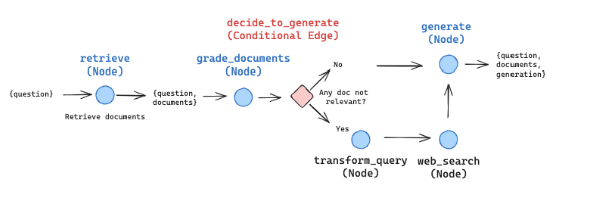

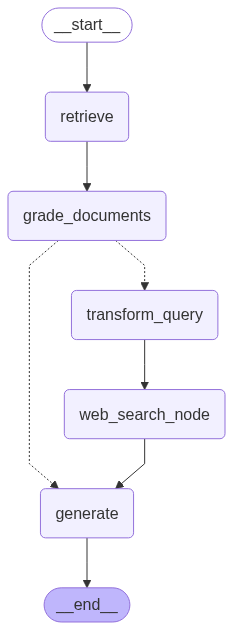

In [97]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [104]:
from pprint import pprint

#Run
inputs = {"question":"What are the types of agent memory?"}
for output in app.stream(inputs):
  for key, value in output.items():
    pprint(f"Node '{key}':")
  print("\n---\n")

#Final generation
pprint(value["generation"])

----RETRIEVE----
"Node 'retrieve':"

---

---Grading the Documnets----
----Grade: Document Relevant
----Grade: Document Relevant
----Grade: Document Relevant
----Grade: Document Relevant
----Verify Graded Documents----
----all docs are relevant to the question, so generate----
"Node 'grade_documents':"

---

----GENERATE----
"Node 'generate':"

---

('The types of agent memory are short-term memory and long-term memory. '
 'Short-term memory involves in-context learning, while long-term memory '
 'allows the agent to retain and recall information over extended periods, '
 'often using an external vector store for retrieval.')


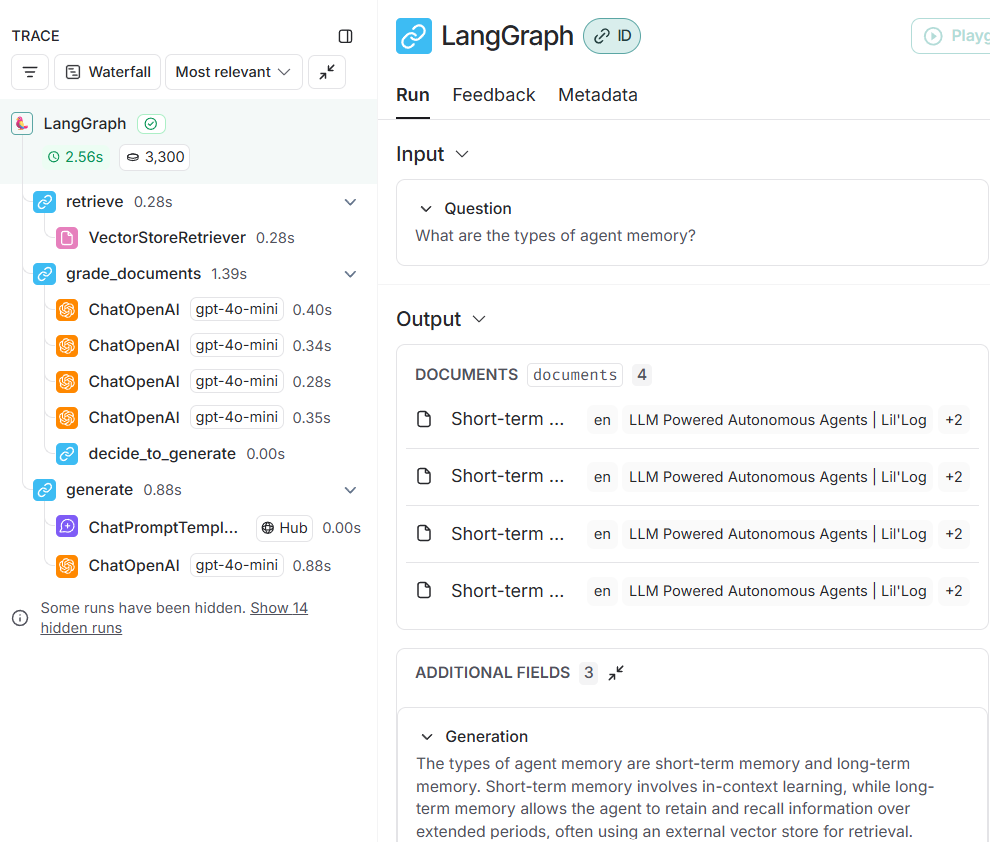

In [99]:
from pprint import pprint

#Run
inputs = {"question":"What are the types of sql queries?"}
for output in app.stream(inputs):
  for key, value in output.items():
    pprint(f"Node '{key}':")
  print("\n---\n")

#Final generation
pprint(value["generation"])

----RETRIEVE----
"Node 'retrieve':"

---

---Grading the Documnets----
----Grade: Document Not Rela=evant
----Grade: Document Not Rela=evant
----Grade: Document Not Rela=evant
----Grade: Document Not Rela=evant
----Verify Graded Documents----
----all docs are not relevant to the question, so transform query----
"Node 'grade_documents':"

---

----Transform Query----
"Node 'transform_query':"

---

----Web Search----
"Node 'web_search_node':"

---

----GENERATE----
"Node 'generate':"

---

('SQL queries can be categorized into five types based on their purposes: \n'
 '\n'
 '1. **DDL (Data Definition Language)** - Used for defining and modifying '
 'database structures (e.g., CREATE, ALTER, DROP).\n'
 '2. **DML (Data Manipulation Language)** - Focuses on manipulating data '
 'within tables (e.g., INSERT, UPDATE, DELETE).\n'
 '3. **DQL (Data Query Language)** - Primarily used for querying and '
 'retrieving data (e.g., SELECT).\n'
 '4. **DCL (Data Control Language)** - Manages access perm

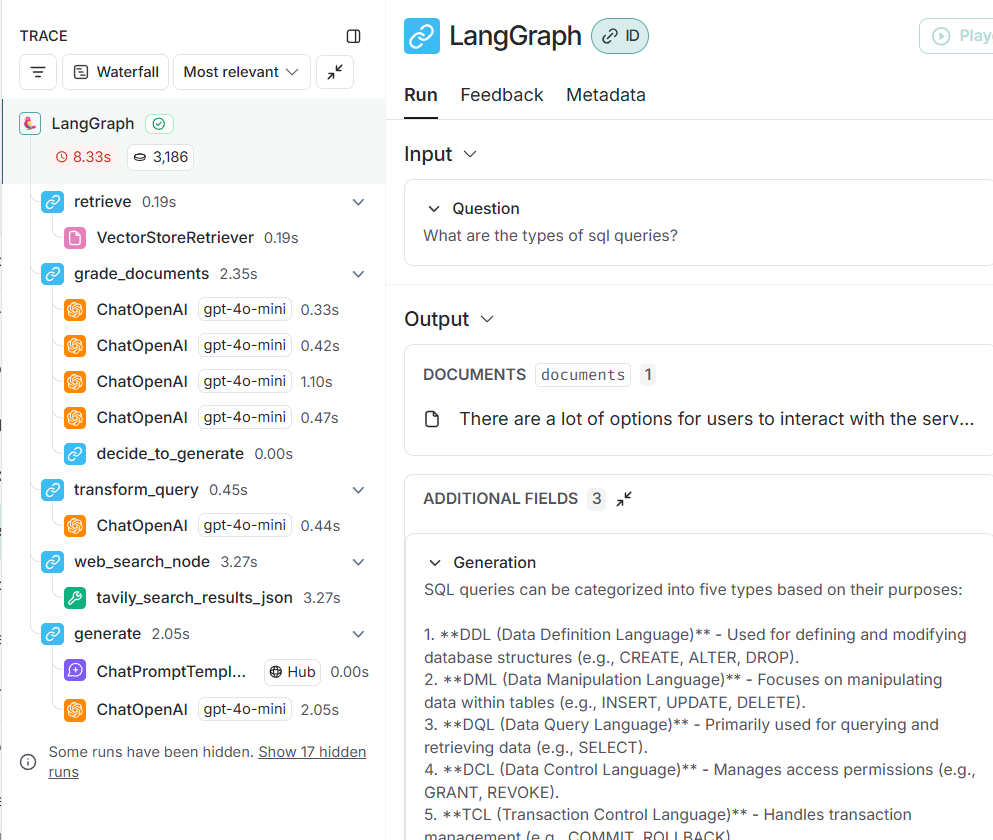

In [100]:
from pprint import pprint

#Run
inputs = {"question":"How does the AlphaCodium Paper work?"}
for output in app.stream(inputs):
  for key, value in output.items():
    #Node
    pprint(f"Node '{key}':")
    #Optional:print full state at each node
    pprint(value["question"], indent = 2, width=80, depth=None)
  print("\n---\n")

#Final generation
pprint(value["generation"])

----RETRIEVE----
"Node 'retrieve':"
'How does the AlphaCodium Paper work?'

---

---Grading the Documnets----
----Grade: Document Not Rela=evant
----Grade: Document Not Rela=evant
----Grade: Document Not Rela=evant
----Grade: Document Not Rela=evant
----Verify Graded Documents----
----all docs are not relevant to the question, so transform query----
"Node 'grade_documents':"
'How does the AlphaCodium Paper work?'

---

----Transform Query----
"Node 'transform_query':"
'What is the mechanism behind the AlphaCodium Paper and how does it function?'

---

----Web Search----
"Node 'web_search_node':"
'What is the mechanism behind the AlphaCodium Paper and how does it function?'

---

----GENERATE----
"Node 'generate':"
'What is the mechanism behind the AlphaCodium Paper and how does it function?'

---

('The AlphaCodium paper proposes a code-oriented iterative flow that involves '
 'generating and refining code through repeated testing against input-output '
 'scenarios. It enhances the pro

In [103]:
from pprint import pprint

#Run
inputs = {"question":"What is the use of Agentic-ai"}
for output in app.stream(inputs):
  for key, value in output.items():
    #Node
    pprint(f"Node '{key}':")
    #Optional:print full state at each node
    pprint(value["question"], indent = 2, width=80, depth=None)
  print("\n---\n")

#Final generation
pprint(value["generation"])

----RETRIEVE----
"Node 'retrieve':"
'What is the use of Agentic-aI'

---

---Grading the Documnets----
----Grade: Document Not Rela=evant
----Grade: Document Not Rela=evant
----Grade: Document Not Rela=evant
----Grade: Document Not Rela=evant
----Verify Graded Documents----
----all docs are not relevant to the question, so transform query----
"Node 'grade_documents':"
'What is the use of Agentic-aI'

---

----Transform Query----
"Node 'transform_query':"
'What are the applications and benefits of Agentic-AI?'

---

----Web Search----
"Node 'web_search_node':"
'What are the applications and benefits of Agentic-AI?'

---

----GENERATE----
"Node 'generate':"
'What are the applications and benefits of Agentic-AI?'

---

('Agentic AI has applications in various sectors, including healthcare, '
 'gaming, and finance, where it optimizes workflows and enhances '
 'decision-making. Its benefits include increased efficiency, reduced need for '
 'human oversight, and the ability to handle complex